In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import pandas as pd

from datetime import datetime

import os
import json
import sys

sys.path.append("../src")
from calculate_I_out import load_ctypes_object, calculate_I_out
from backups import create_backup, recover_backup

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from scipy import optimize as scop

In [3]:
filename_so = './../data/functions/libtest.so'
ctypes_object = load_ctypes_object(filename_so)

$$ \frac{\partial V_{p}}{\partial t} = \frac{V_{c} - V_{p}}{C_{p}*R_{p}} \\ $$
$$ \frac{\partial V_{m}}{\partial t} = \frac{V_{p} + V_{off} - V_{m}}{C_{m}*R_{s}} - \frac{I_{ion}+I_{leak}}{C_m} \\ $$
$$ \frac{\partial m}{\partial t} = \frac{m_{inf} - m}{\tau_{m}}  \\ $$
$$ \frac{\partial h}{\partial t} = \frac{h_{inf} - h}{\tau_{h}}  \\ $$
$$
I_{m} = C_{m} *\frac{\partial V_{m}}{\partial t} \\
I_{p} = C_{p} *\frac{\partial V_{p}}{\partial t} \\
I_{leak} = g_{leak} * V_{m}
$$

In [4]:
k_list = np.array([77, 1077, 2077, 4077])
v_list = np.array([-80, -70, -80, -80])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list + 5000 * l])
    v_all = np.concatenate([v_all, v_list+[0, 0, 0, 5 * l]])
v_all = np.concatenate([v_all, [-80]])
t = np.load('../data/time.npy')
t_all = np.concatenate([t for k in range(20)])

In [5]:
k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80.0, -70.0, -80.0, -10.0, -80.0])

In [6]:
def log_x(a):
    b = a.copy()
    b[2: 10] = np.log(a[2: 10])
    b[14: 18] = np.log(a[14: 18])
    return(b)

In [7]:
# mpl_style_filename = '../styles/general.mplstyle'

# plt.style.use(mpl_style_filename)

In [8]:
t_step = np.load("./time_1e-5.npy")
t_step

array([0.000e+00, 1.000e-05, 2.000e-05, ..., 4.607e-02, 4.608e-02,
       4.609e-02])

In [9]:
# with open("../data/constants/constants_default.json", 'w') as f:
#     json.dump(param_dict, f, indent=4)

In [10]:
with open("../data/constants/constants_default.json", 'r') as f:
    constants_dict = json.load(f)
    keys, values = list(constants_dict.keys()), list(constants_dict.values())

In [49]:
p0 = np.array(values)

x_true_log = np.concatenate((np.log(p0[:-1]),p0[-1:]))

v_list = v_all
k_list = k_all
dt = t[1] - t[0]

kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t_step,
              log_scale = True,
              graph = False,
              calculate_circle = ctypes_object.calculate_circle,
              # sample_weights = sample_weight,
              )

data = calculate_I_out(x_true_log, kwargs)

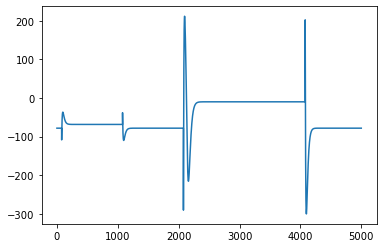

In [12]:
plt.plot(data)

In [13]:
def loss(x, *args):
    kwargs = args[-1]
    data = args[0]
    sample_weight = kwargs.get('sample_weight', None)
    
    I_out = calculate_I_out(x, *args)
    
    if np.any(np.isnan(I_out)):
        return np.inf
    if np.any(np.isinf(I_out)):
        return np.inf
        
    return MSE(data, I_out, sample_weight=sample_weight)

In [26]:
%%timeit
loss(x_true_log, data, kwargs)

9.66 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
kwargs['t'] = t

x0 = x_true_log + 0.23
bounds = np.vstack([x_true_log  - 2, x_true_log + 2]).T#

loss(x0, data, kwargs)

1223.2460184877827

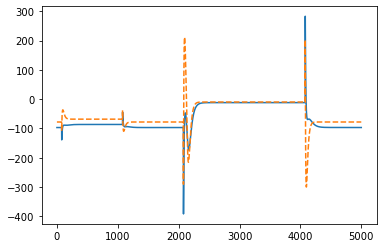

In [15]:
plt.plot(calculate_I_out(x0, kwargs))
plt.plot(data, '--')

### minimize

In [37]:
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs), method='Nelder-Mead',
                    options={'adaptive': True, 'maxiter': 10})

In [38]:
loss(res.x, data, kwargs)

794.4596214612444

In [39]:
print('error in param =' , x_true_log - res.x)

error in param = [-1.72655301 -0.19468941 -0.32477468 -0.24753258 -0.22257607 -0.26216027
 -0.22240892 -0.2598048  -0.24338498 -0.24594013 -0.26251457 -0.19521012
 -0.23920534 -0.2452309  -0.21553902 -0.29780511 -0.27471899 -0.25469106
 -0.23090331 -0.24010065 -0.24597414 -0.24097704 -0.2259038  -0.23002693
 -0.22997753 -0.19473011 -0.23090331]


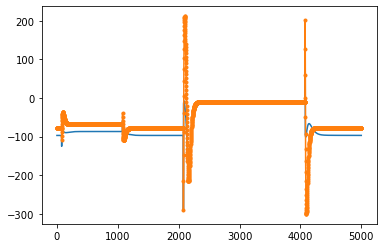

In [19]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(data, '.-')

 ### real_data_minimize


In [21]:
sample_weight = np.zeros(5000)
w1 = 1
w2 = 5
w3 = 10
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2400] += 30
    sample_weight[2400:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2


In [25]:
folder_data = '../data/training'

content = sorted(os.listdir(folder_data))
list(enumerate(content))

[(0, '2020_12_19_0035 I-V INa 11,65 pF.atf'),
 (1, '2020_12_21_0007 I-V INa 15.80pF.atf'),
 (2, '2020_12_22_0006 I-V INa 25.16pF.atf'),
 (3, '2020_12_22_0032 I-V INa 21.05pF.atf'),
 (4, '2020_12_23_0007 I-V INa E4031 33.16pF.atf'),
 (5, '2020_12_26_0000 I-V INa 36.60pF.atf'),
 (6, '2020_12_26_0014 I-V INa 15.78pF.atf')]

In [34]:
index_data = 0
filename_data = os.path.join(folder_data, content[index_data])

real_data = pd.read_csv(filename_data, delimiter= '\t', header=None, skiprows = 11)


index_step = 14
real_data_small = real_data[index_step]

#real_data_all = no_drift(real_data)#np.concatenate([real_data[k] for k in range(1,21)])

real_data_all = np.concatenate([real_data[k] for k in range(1, real_data.shape[1])])
sample_weight_all = np.concatenate([sample_weight for k in range(1, real_data.shape[1])])
                   
bounds = ([1e-18, 1e-13,#C_f , C 
           1e-06, 1e-06, 1e-03, 1e-03,# a0_m , b0_m , delta_m , s_m 
           1e-06, 1e-06, 1e-03, 1e-03,#a0_h , b0_h , delta_h , s_h
           1e-06, 1e-06, 1e-03, 1e-03, 1e-8,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+05, 1e+03, 1e-05, 1e-05,#R , R_f , g_max , g_leak
           1e-04, 1e-04, 1e-04, 1e-04,#v_half_m , v_half_h , k_m , k_h
           1e-02, 1e-02, 1e-04, -5e+01],# x_c_comp,x_r-Comp alpha v_off
          
          
          [1e-10, 1e-10,#C_f , C 
           1e+06, 1e+06, 1e+03, 1e+03,# a0_m , b0_m , delta_m , s_m 
           1e+06, 1e+06, 1e+03, 1e+03,#a0_h , b0_h , delta_h , s_h
           1e+06, 1e+06, 1e+03, 1e+03, 1e+06,#a0_j , b0_j , delta_j , s_j, tau_j_const
           1e+10, 1e+12, 1e+05, 1e+05, #R , R_f , g_max , g_leak
           1e+02, 1e+02, 1e+02, 1e+02,#v_half_m , v_half_h , k_m , k_h
           1e+01, 1e+01, 1e+04, 5e+01])# x_c_comp,x_r-Comp alpha v_off
log_bounds = np.vstack([np.concatenate((np.log(bounds[0][:-1]), bounds[0][-1:]))
                        , np.concatenate((np.log(bounds[1][:-1]), bounds[1][-1:]))]).T

kwargs_for_count = dict(v_list = v_all,
                        k_list = k_all,
                        t = t_all,
                        log_scale = True,
                        graph = False,
                        sample_weight = sample_weight_all,
                        calculate_circle = ctypes_object.calculate_circle,
                        )

In [46]:
len(t_all)

100000

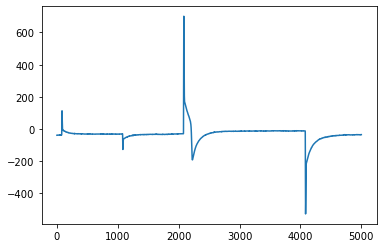

In [35]:
plt.plot(real_data_small)

In [41]:
res = scop.minimize(loss, x0, bounds=bounds, args=(data, kwargs), method='Nelder-Mead',
                    options={'adaptive': True, 'maxiter': 10})

In [40]:
x = x_true_log

for k in range(5):
    res = scop.minimize(loss, x, bounds=log_bounds,
                        args=(real_data_all, kwargs_for_count),
                        method = 'Nelder-Mead',
                        options={ 'adaptive':True, 'maxiter':10})
    
    print('loop ',k ,': res.x = ', res.x,';\n          loss = ', loss(res.x, real_data_all, kwargs_for_count))
    x = res.x
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

/home/andrey/WORK/HPL/Code/conda_env/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


ArgumentError: argument 5: <class 'TypeError'>: array must have data type float64

In [47]:
#np.save("res_maxiter_5000",res.x)
#np.save('maxiter_5000_best_fit',calculate_I_out(res.x, kwargs_for_count))
#create_backup(res, calculate_I_out, kwargs, real_data_all, sample_weight_all)

In [ ]:
kwargs = dict(v_list = v_list_1,
              k_list = k_list_1,
              t = t_step,
              log_scale = True,
              graph = False,
              calculate_circle = ctypes_object.calculate_circle,
              # sample_weights = sample_weight,
              )

In [62]:
kwargs= dict(v_list = v_all,
              k_list = k_all,
              t = t_all,
              log_scale = True,
              graph = True,
              #sample_weight = sample_weight_all,
              calculate_circle = ctypes_object.calculate_circle,
)

plt.plot(calculate_I_out(res.x, kwargs_for_count), label = 'calculated')
plt.plot(real_data_all,'--', label = 'real_data')

plt.legend()

ArgumentError: argument 5: <class 'TypeError'>: array must have data type float64

In [22]:
for k in range(len(res.x)):
    print(names[k], ' = ',np.exp(res.x)[k])

NameError: name 'res' is not defined

### differential_evolution

In [37]:
%%time
res = scop.differential_evolution(loss,
                                  bounds=log_bounds,
                                  args=(real_data_all, kwargs_for_count),
                                  maxiter=10, # I don't want to wait too long
                                  disp=True,
                                  popsize = 5,
                                  workers = 1,
                                  seed=2)


differential_evolution step 1: f(x)= 1893.31


/home/nik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


differential_evolution step 2: f(x)= 1838.42


/home/nik/.local/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


CPU times: user 45.6 s, sys: 7.82 s, total: 53.5 s
Wall time: 53.5 s


In [38]:
loss(res.x, real_data_all, kwargs_for_count)

1008.6634987243593

<IPython.core.display.Javascript object>


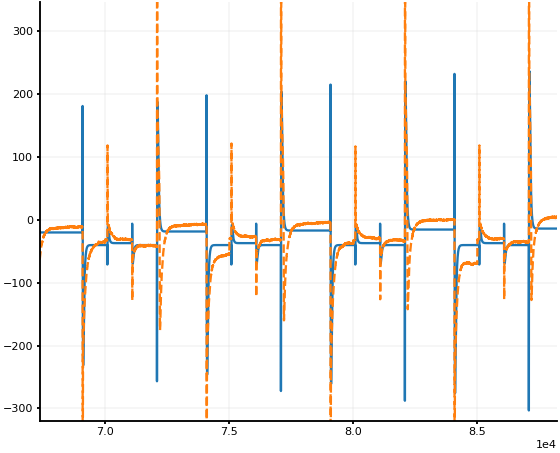

In [40]:
plt.plot(calculate_I_out(res.x, kwargs_for_count))
plt.plot(real_data_all, '--')
#plt.xlim(0, 1000)

### dual_annealing

In [ ]:
%%time
#res = scop.dual_annealing(loss, bounds=log_bounds, x0 = x_true_log, args=(real_data_small, kwargs_for_count), seed=42)

In [ ]:
res

In [ ]:
loss(res.x, real_data_small, kwargs)

In [ ]:
plt.plot(calculate_I_out(res.x, kwargs))
plt.plot(real_data_small, '--')